In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
%matplotlib inline

from tools import *

import os
import warnings
warnings.filterwarnings('ignore')

import gc

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit, cross_val_score

CACHE_PATH = '/Users/angus/Downloads/kaggle/'
cpath = lambda x: CACHE_PATH + x

# Potential Features
* number of H, C, N interactions associated to atom_index_0
* descriptive stats (min, max, mean, std) of the interactions
* closest, second closest and third closest (i.e. min1, min2, min3) interactions 
    since the closer they are the more they interact with the protons
* transformations of features
https://datascience.stackexchange.com/questions/10640/how-to-perform-feature-engineering-on-unknown-features
* angle b/w dipole and position
* inner produt of magneti shielding tensor

In [75]:
df = pd.read_pickle(cpath('df_feats_enc'))

In [76]:
df_structures = pd.read_csv('../input/structures.csv')

In [77]:
df = get_portion(df, 0.1)
df.shape

(467688, 65)

In [35]:
feats = [
#     'molecule_name', 'atom_index_0', 'atom_index_1', 'scalar_coupling_constant',
#     'fc', 'sd', 'pso', 'dso', 'mulliken_charge',
    'dip_x', 'dip_y', 'dip_z',
    'dip_mag',
#     'potential_energy',
#     'XX', 'YX', 'ZX', 'XY','YY', 'ZY', 'XZ', 'YZ', 'ZZ',
#     'atom_0',
    'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
#     'dist',
#     'n_C', 'n_H', 'n_N',
#     'mol_min_dist', 'mol_max_dist', 'mol_mean_dist', 'mol_med_dist', 'mol_kur_dist', 'mol_std_dist',
#     'atom_0_min_dist', 'atom_0_max_dist', 'atom_0_mean_dist', 'atom_0_med_dist', 'atom_0_kur_dist', 'atom_0_std_dist',
#     'atom_1_min_dist', 'atom_1_max_dist', 'atom_1_mean_dist', 'atom_1_med_dist', 'atom_1_kur_dist', 'atom_1_std_dist',
#     'nearby_C', 'nearby_H', 'nearby_N',
    'type',
    'atom_1',
]
meta_feats = ['fc_pred', 'sd_pred', 'pso_pred', 'dso_pred', 'mulliken_charge_pred']
meta_orig = ['fc', 'sd', 'pso', 'dso', 'mulliken_charge']
categoricals = ['type', 'atom_1']
feats = list(set(feats) - set(categoricals))

In [9]:
def my_concat(*args):
    df = args[0]
    for col in args[1:]:
        df = pd.concat([df, col], axis=1)
    return df

In [43]:
transforms = [
    np.exp,
    np.log,
    lambda x: np.log(1 + x),
    np.sqrt,
    np.arctan,
    np.reciprocal,
    np.sin
]

In [44]:
t_lst = ['dip_angle']
for i, t in enumerate(transforms):
    df[f'transform_{i}'] = t(df['dist'])
    t_lst.append(f'transform_{i}')

In [51]:
from sklearn.preprocessing import MinMaxScaler

In [79]:
numeric_cols = df.columns[df.dtypes.apply(lambda c: np.issubdtype(c, np.float))]
numeric_cols

Index(['scalar_coupling_constant', 'fc', 'sd', 'pso', 'dso', 'mulliken_charge',
       'dip_x', 'dip_y', 'dip_z', 'potential_energy', 'XX', 'YX', 'ZX', 'XY',
       'YY', 'ZY', 'XZ', 'YZ', 'ZZ', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'dist', 'mol_min_dist', 'mol_max_dist', 'mol_mean_dist', 'mol_med_dist',
       'mol_kur_dist', 'mol_std_dist', 'atom_0_min_dist', 'atom_0_max_dist',
       'atom_0_mean_dist', 'atom_0_med_dist', 'atom_0_kur_dist',
       'atom_0_std_dist', 'atom_1_min_dist', 'atom_1_max_dist',
       'atom_1_mean_dist', 'atom_1_med_dist', 'atom_1_kur_dist',
       'atom_1_std_dist', 'nearby_C', 'nearby_H', 'nearby_N'],
      dtype='object')

In [70]:
scaler = MinMaxScaler()
df['dip_angle_scaled'] = scaler.fit_transform(df[['dip_angle']])

In [71]:
stratify_by = ['type']
df_ = df.groupby(stratify_by, group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))
df_.groupby(stratify_by).size()

type
1JHC    10
1JHN    10
2JHC    10
2JHH    10
2JHN    10
3JHC    10
3JHH    10
3JHN    10
dtype: int64

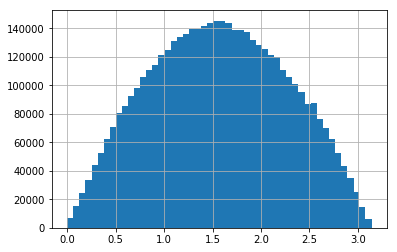

In [72]:
df.dip_angle.hist(bins=50)

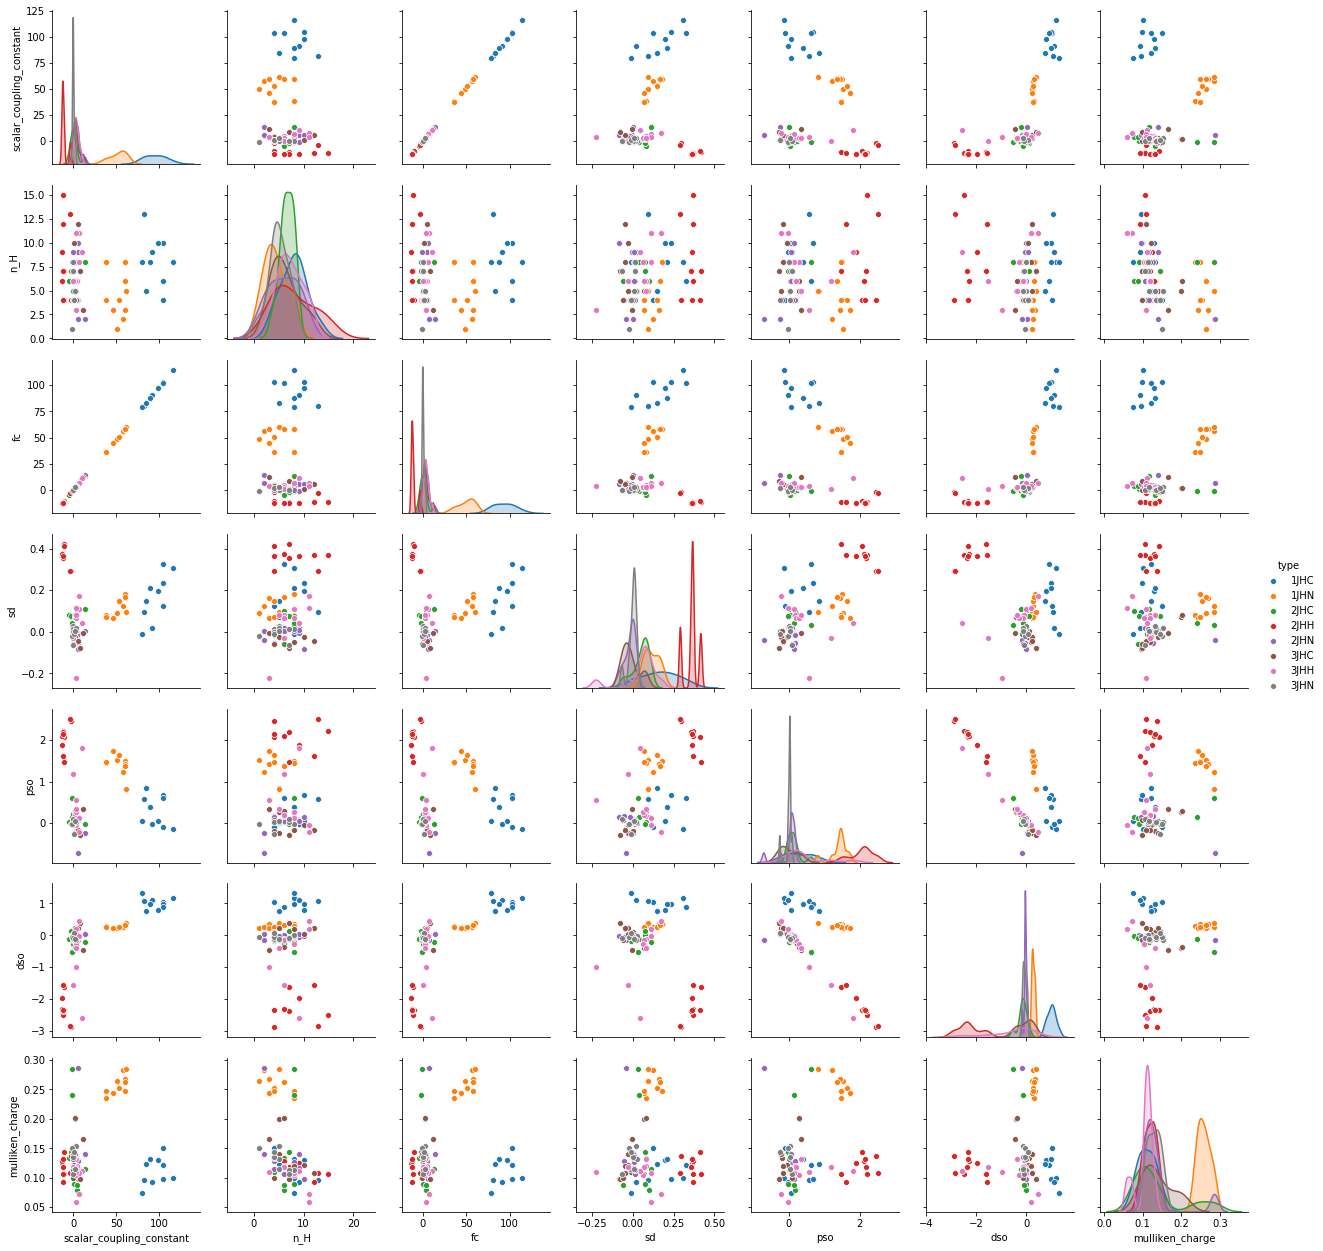

In [82]:
sns.pairplot(df_[['scalar_coupling_constant', 'n_H'] + meta_orig + ['type']], hue='type')